In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='./data',  
                            transform=ToTensor(),
                            target_transform=lambda y: torch.randint(0, 10, (1,)).item(),
                            download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
val_size = 10000
train_size = len(dataset) - val_size

# Set a random seed to always use the same trainning subset
random_seed = 22
torch.manual_seed(random_seed);

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])
tensor([2, 5, 9, 4, 1, 9, 3, 6, 4, 9, 3, 3, 5, 4, 5, 7, 0, 7, 5, 4, 3, 1, 8, 0,
        9, 0, 5, 3, 3, 4, 2, 6, 4, 1, 0, 7, 1, 7, 6, 0, 7, 8, 5, 1, 5, 7, 5, 4,
        1, 0, 2, 6, 7, 1, 1, 6, 7, 8, 4, 8, 4, 4, 2, 7, 6, 8, 7, 0, 2, 0, 7, 4,
        5, 9, 6, 2, 7, 8, 3, 4, 4, 6, 5, 1, 1, 2, 2, 0, 0, 6, 3, 2, 4, 0, 7, 5,
        8, 8, 2, 8, 5, 3, 6, 8, 4, 7, 2, 1, 3, 9, 6, 9, 7, 9, 9, 5, 2, 0, 5, 6,
        8, 5, 1, 6, 5, 6, 1, 2])


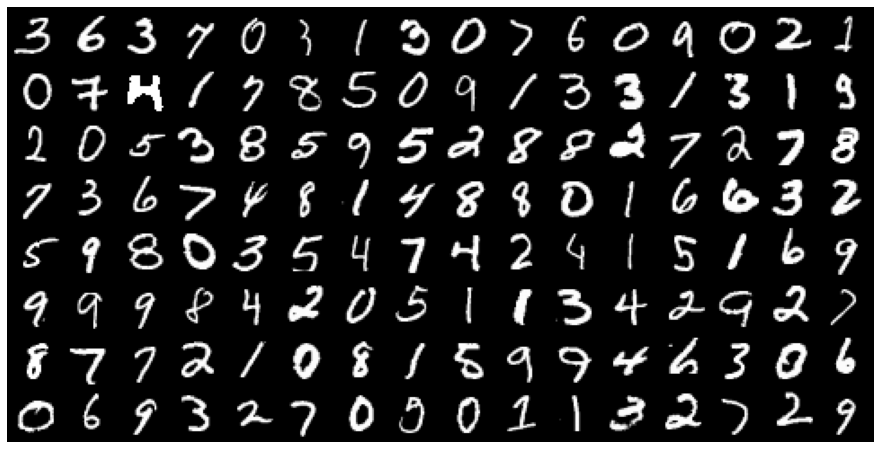

In [5]:
#Visualize a batch of data
for images, labels in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)));
    print(labels);
    break

In [6]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 3 hidden layer"""
    def __init__(self, in_size, hidden_size_1, hidden_size_2, hidden_size_3, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, hidden_size_1)
        # hidden layer 2
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        # hidden layer 3
        self.linear3 = nn.Linear(hidden_size_2, hidden_size_3)
        # output layer
        self.linear4 = nn.Linear(hidden_size_3, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
input_size = 784
hidden_size_1 = 64
hidden_size_2 = 128
hidden_size_3 = 64
num_classes = 10

In [8]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
def evaluate(model, val_loader):
    #Evaluate the model's performance on the validation set
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    #Train the model using gradient descent
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
#Define model
model = MnistModel(input_size, 
                   hidden_size_1, 
                   hidden_size_2, 
                   hidden_size_3,
                   num_classes)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
count_parameters(model)

67466

In [14]:
#Place dataloaders and the model into GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [15]:
#Sanity checking
evaluate(model, val_loader)

{'val_loss': 2.305912494659424, 'val_acc': 0.10048828274011612}

In [18]:
num_epochs = 100
lr = 0.01
opt_func = torch.optim.SGD

In [19]:
#Start tranning
history=[]
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 2.3027, val_loss: 2.3025, val_acc: 0.1041
Epoch [1], train_loss: 2.3026, val_loss: 2.3027, val_acc: 0.1026
Epoch [2], train_loss: 2.3026, val_loss: 2.3029, val_acc: 0.0925
Epoch [3], train_loss: 2.3025, val_loss: 2.3025, val_acc: 0.0974
Epoch [4], train_loss: 2.3027, val_loss: 2.3025, val_acc: 0.1019
Epoch [5], train_loss: 2.3026, val_loss: 2.3024, val_acc: 0.1052
Epoch [6], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.0973
Epoch [7], train_loss: 2.3025, val_loss: 2.3025, val_acc: 0.1057
Epoch [8], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.0979
Epoch [9], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.0962
Epoch [10], train_loss: 2.3026, val_loss: 2.3026, val_acc: 0.1019
Epoch [11], train_loss: 2.3026, val_loss: 2.3024, val_acc: 0.1068
Epoch [12], train_loss: 2.3026, val_loss: 2.3025, val_acc: 0.1011
Epoch [13], train_loss: 2.3026, val_loss: 2.3025, val_acc: 0.1021
Epoch [14], train_loss: 2.3026, val_loss: 2.3025, val_acc: 0.1077
Epoch [15], train_lo

In [ ]:
num_epochs = 100
lr = 0.01
history += fit(num_epochs, lr, model, train_loader, val_loader)

In [ ]:
num_epochs = 200
lr = 0.001
history += fit(num_epochs, lr, model, train_loader, val_loader)

In [ ]:
num_epochs = 200
lr = 0.001
history += fit(num_epochs, lr, model, train_loader, val_loader)

In [ ]:
num_epochs = 500
lr = 0.001
history += fit(num_epochs, lr, model, train_loader, val_loader)

In [20]:
def plot_losses(train_losses,val_losses):
    plt.plot(train_losses, '-', label="Train")
    plt.plot(val_losses, '-', label="Test")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="upper right");

In [21]:
train_losses = [x['train_loss'] for x in history]
val_losses = [x['val_loss'] for x in history]

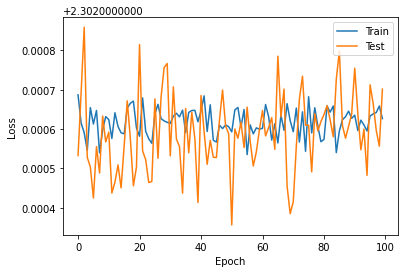

In [22]:
plot_losses(train_losses,val_losses)